**What we do in this notebook:**

Here we use Hierarchical clustering to cluster our song data into clusters and then recommend songs from the same cluster. The idea is that songs in the same cluster are more likely to be similar. Thus given, a playlist, we will recommend it songs that are in the same cluster most of the playlists' songs are but not in the playlist.

Types of Clustering
We used Agglomerative clustering (Bottom-up approach) instead of Divisive clustering since it is less complex and given how time consuming our calculations are, it will be less-expensive to compute while producing similar results.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import euclidean
from collections import defaultdict
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

In [11]:
# Reading the dataframe to resuming working
df = pd.read_csv("data/Sample_from_Million_Playlist.csv")

# Reading the data from saved file
# This is the dataframe we will implement our mode
df_spotify = pd.read_csv("data/100_Sample_MilPlay_Spotify.csv")


In [12]:
# Cleaning the data frame and removing features we don't need
df_spotify = df_spotify.drop_duplicates(['track_uri'])
df_spotify_tracks = df_spotify['track_uri']
df_spotify_track_names = df_spotify['track_name']

# Cleaning the data frame and removing features we don't need
df_spotify = df_spotify.drop_duplicates(['track_uri']).reset_index()
df_spotify_tracks = df_spotify['track_uri']
df_spotify_track_names = df_spotify['track_name']

# We will be using the clean df to implement our model
df_spotify_clean = df_spotify.drop(columns=['index', 'pid','pos','artist_name','track_uri','artist_uri','track_name','album_uri','album_name','type','id','uri','track_href','analysis_url','duration_ms.1','mode'])
df_spotify_clean.head(10)

,duration_ms,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,199453,0.376,0.821,0,-3.974,0.1040,0.0785,0.000000,0.0823,0.331,120.462,4
1,260640,0.585,0.421,7,-9.593,0.0707,0.1060,0.000010,0.1400,0.240,132.986,3
2,239320,0.504,0.705,6,-8.205,0.3640,0.0752,0.000000,0.1280,0.584,175.483,4
3,206240,0.771,0.647,5,-5.127,0.3760,0.2940,0.000000,0.3700,0.678,155.914,4
4,235653,0.480,0.682,7,-4.940,0.1300,0.0696,0.000000,0.0463,0.506,167.939,3
5,226013,0.511,0.596,0,-6.560,0.2240,0.5300,0.000000,0.0798,0.554,158.063,4
6,261160,0.422,0.712,11,-5.907,0.1000,0.2730,0.000000,0.0510,0.471,78.454,4
7,240147,0.418,0.111,1,-14.848,0.0389,0.9530,0.003420,0.0982,0.228,82.508,4
8,219214,0.377,0.638,4,-5.754,0.0545,0.2130,0.000080,0.1200,0.369,92.644,4
9,283466,0.395,0.676,0,-5.460,0.0498,0.6080,0.000049,0.1170,0.315,142.929,5


In [13]:
# Standardizing the data
scaler = MinMaxScaler()
scaler.fit(df_spotify_clean)
df_spotify_clean_scaled = scaler.transform(df_spotify_clean)

In [14]:
# Improved model

def generate_playlist_hierarchical_cluster(playlist, df_scaled_features, info_df, cluster, random_state = 10):
    
    '''
    Input:
    playlist = Playlist based on which to provide recommendations 
    df_scaled_features = df with all the scaled audio features of our songs
    info_df = The df with all the songs and track info and audio features
    cluster = agglomerative clustering model.
    random_state = Random state for k-clustering 
    
    Output:
    recs = A df that will be the recommended playlist
    '''
    pid = list(info_df[info_df['track_uri'].isin(playlist)]['pid'].value_counts().index)[0]
    df_k = pd.DataFrame(df_scaled_features.copy())
    
    # get label
    label = cluster.labels_
    # Assigning labels to each song
    df_k['cluster_label'] = label
    
    # For a given playlist, checking which cluster label the playlist had the highest
    mode_cluster = list(df_k[info_df['pid'] == pid]['cluster_label'].value_counts().index)[0]
    
    # Finding songs not on our playlist by with same cluster label
    our_df = info_df[~(info_df['track_uri'].isin(playlist)) & (df_k['cluster_label'] == mode_cluster)]

    # Then among those songs, taking a single song from each artist 
    # The loop starts with the artist with the highest songs and then goes down and repeats
    # We do this until our recommendation is complete
    
    artist_names = list(info_df[df_k['cluster_label'] == mode_cluster]['artist_name'].value_counts().index)
    recs = []
    counter = 0
    while (len(recs) < 2*len(playlist)) and (counter < len(our_df[our_df['artist_name'] == artist_names[0]]['track_uri'])):    
        for artist in artist_names:
                songs = our_df[our_df['artist_name'] == artist]['track_uri']
                if len(songs) > counter + 1:
                    recs.append(list(songs)[counter])
        counter += 1
    return info_df[info_df['track_uri'].isin(recs)]['track_name'].iloc[0:len(playlist)]  

In [15]:
# This is one of the metrics that can be used to understand the precision of the recommendation
def r_precision(prediction, validation):
    score = np.sum(validation.isin(prediction))/validation.shape[0]
    return score

### NDCG Code Source: https://gist.github.com/bwhite/3726239
def dcg_at_k(r, k, method=0):
    r = np.asfarray(r)[:k]
    if r.size:
        if method == 0:
            return r[0] + np.sum(r[1:] / np.log2(np.arange(2, r.size + 1)))
        elif method == 1:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.


def ndcg_at_k(r, k, method=0):
    dcg_max = dcg_at_k(sorted(r, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(r, k, method) / dcg_max

In [16]:
# Testing model

# Choosing pids with at least 50 songs such that our model gets at least 25 songs to work with
# The average playlist in our data set contains 52 songs
# So, if we take 100 songs at least and do a .5 train-test split
# The model will produce 50 recommendations and get tested on a 25 song playlist on average which is reasonable

pids = list(df_spotify['pid'].value_counts()[df_spotify['pid'].value_counts() > 50].index)[0:30]

mean_rprec = []
mean_ndcgs = []

for num_clusters in range(1,10):
    r_precisions = []
    ndcgs = []
    cluster = AgglomerativeClustering(n_clusters=num_clusters, affinity='euclidean', linkage='ward')
    df_k = pd.DataFrame(df_spotify_clean_scaled.copy())

    # fit clusters
    cluster.fit_predict(df_k)
    for pid in pids:
        train, test = train_test_split(df_spotify[df_spotify['pid'] == pid], test_size=0.50, random_state = 24)
        prediction = generate_playlist_hierarchical_cluster(train['track_uri'], df_spotify_clean_scaled, df_spotify, cluster)
        r = r_precision(prediction, test['track_name'])
        r_precisions.append(r)

        rx = np.zeros(len((prediction)))
        for i, p in enumerate(prediction):
            if np.any(test['track_name'].isin([p])):              
                rx[i] = 1
        ndcgs.append(ndcg_at_k(rx, len(rx)))
    
    print("Number of clusters: " + str(num_clusters))
    mean_rprec.append(np.mean(r_precisions))
    mean_ndcgs.append(np.mean(ndcgs))

Number of clusters: 1
Number of clusters: 2
Number of clusters: 3
Number of clusters: 4
Number of clusters: 5
Number of clusters: 6
Number of clusters: 7
Number of clusters: 8
Number of clusters: 9


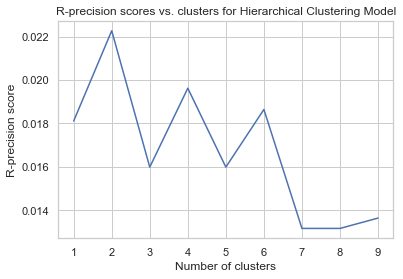

In [23]:
plt.plot(np.arange(1, 10), mean_rprec)
plt.title("R-precision scores vs. clusters for Hierarchical Clustering Model")
plt.xlabel("Number of clusters")
plt.ylabel("R-precision score")
plt.savefig("data/HC_R.png")

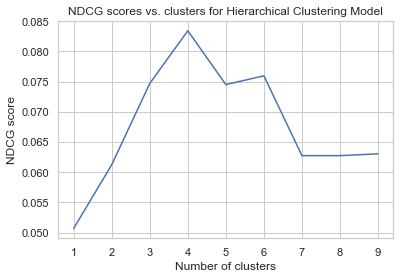

In [22]:
plt.plot(np.arange(1, 10), mean_ndcgs)
plt.title("NDCG scores vs. clusters for Hierarchical Clustering Model")
plt.xlabel("Number of clusters")
plt.ylabel("NDCG score")
plt.savefig("data/HC_NDCG.png")

In [24]:
best_cluster = np.argmax(np.array(mean_rprec)+np.array(mean_ndcgs))
print("Best cluster:{}". format(best_cluster + 1))
print("r precision for that cluster: {}".format(mean_rprec[best_cluster]))
print("NDCGs for that cluster: {}".format(mean_ndcgs[best_cluster]))

Best cluster:4
r precision for that cluster: 0.01961842753064936
NDCGs for that cluster: 0.0834216104106089
